<a href="https://colab.research.google.com/github/gulierus/VU_RG/blob/main/GP_VS_PFN_EXP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO: Přepsat save model

In [ ]:
# =============================================
# SETUP repo + dependencies
# =============================================
# @title Setup old
!rm -rf TransformersCanDoBayesianInference
!git clone https://github.com/automl/TransformersCanDoBayesianInference.git
!pip install -q gpytorch pyro-ppl scikit-learn matplotlib

import sys
sys.path.insert(0, '/content/TransformersCanDoBayesianInference')

import torch
import numpy as np
from torch import nn

# Import jejich modulů
import bar_distribution
import transformer as pfn_transformer
import encoders
import positional_encodings
import utils

print(f" PyTorch: {torch.__version__}")
print(f" CUDA: {torch.cuda.is_available()}")
print(" Setup complete!")

Cloning into 'TransformersCanDoBayesianInference'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 123 (delta 14), reused 8 (delta 8), pack-reused 105 (from 1)
Receiving objects: 100% (123/123), 107.94 MiB | 29.71 MiB/s, done.
Resolving deltas: 100% (46/46), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.0 MB/s eta 0:00:00
✓ PyTorch: 2.9.0+cu126
✓ CUDA: True
✓ Setup complete!


In [ ]:
# =============================================
# SETUP S JEJICH SKUTEČNÝMI MODULY
# =============================================
!rm -rf TransformersCanDoBayesianInference
!git clone https://github.com/automl/TransformersCanDoBayesianInference.git
%cd TransformersCanDoBayesianInference

# Oprav jen botorch problém
!sed -i 's/, fast_gp_mix//g' priors/__init__.py
!sed -i 's/, fast_gp_mix//g' priors/binarized_regression.py

# ROBUSTNÍ OPRAVA fast_gp_mix.py pomocí Pythonu (sed může selhat)
import os
fn = 'priors/fast_gp_mix.py'
if os.path.exists(fn):
    with open(fn, 'r') as f:
        content = f.read()
    # Nahradíme import definicí konstanty
    content = content.replace(
        'from botorch.models.gp_regression import MIN_INFERRED_NOISE_LEVEL',
        'MIN_INFERRED_NOISE_LEVEL = 1e-4 # Patched by Colab'
    )
    with open(fn, 'w') as f:
        f.write(content)
    print(f"✓ {fn} was patched successfully.")

# 2) OPRAVA priors/__init__.py - odstraň binarized_regression z importu
fn2 = 'priors/__init__.py'
if os.path.exists(fn2):
    with open(fn2, 'r') as f:
        content = f.read()


    content = content.replace(
        'from . import fast_gp, gp, ridge, stroke, mlp, omniglot, binarized_regression, pyro',
        'from . import fast_gp, gp, ridge, stroke, mlp, omniglot, pyro'
    )

    with open(fn2, 'w') as f:
        f.write(content)
    print(f"✓ {fn2} patched (binarized_regression odstraněn)")

!rm priors/binarized_regression.py
print("✓ priors/binarized_regression.py SMAZÁN")

!pip install -q gpytorch pyro-ppl scikit-learn matplotlib catboost openml botorch

import sys
sys.path.insert(0, '/content/TransformersCanDoBayesianInference')

import torch
from torch import nn
import numpy as np

from transformer import TransformerModel
import encoders
import positional_encodings
import bar_distribution
import utils
from train import Losses

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
print(" moduly naimportovány")

Cloning into 'TransformersCanDoBayesianInference'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 123 (delta 17), reused 8 (delta 8), pack-reused 102 (from 1)
Receiving objects: 100% (123/123), 107.94 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/TransformersCanDoBayesianInference
✓ priors/fast_gp_mix.py was patched successfully.
✓ priors/__init__.py patched (binarized_regression odstraněn)
✓ priors/binarized_regression.py SMAZÁN
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.6 MB/s eta 0:00:

In [ ]:
# =============================================
# GP PRIOR
# =============================================
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

class SimpleGPPrior:
    def __init__(self, length_scale=0.6, output_scale=1.0, noise=1e-4):
        self.length_scale = length_scale
        self.output_scale = output_scale
        self.noise = noise
        self.kernel = output_scale * RBF(length_scale=length_scale)

    def sample_dataset(self, n_points=100, num_features=1):
        X = np.random.uniform(0, 1, (n_points, num_features))
        X = np.sort(X, axis=0)

        gp = GaussianProcessRegressor(
            kernel=self.kernel,
            alpha=self.noise,
            random_state=None
        )

        y = gp.sample_y(X, n_samples=1, random_state=None).flatten()
        return X, y

print(" GP Prior definován")

 GP Prior definován


In [ ]:
# =============================================
# Configuration
# =============================================

# GP hyperparameters
hps = {
    'length_scale': 0.6,
    'output_scale': 1.0,
    'noise': 1e-4
}

# Data
num_features = 1
bptt = 500  # Max points per dataset

# Training
epochs = 50
steps_per_epoch = 100
batch_size = 8
aggregate_k_gradients = 8

# Model
emsize = 256
nhead = 4
nlayers = 6
nhid = emsize * 2

# Riemann Distribution
num_borders = 1000

print(f" Configuration:")
print(f" GP length_scale: {hps['length_scale']}")
print(f" Total datasets: ~{epochs * steps_per_epoch * batch_size:,}")

Configuration:
  GP length_scale: 0.6
  Total datasets: ~40,000


In [ ]:
# =============================================
# RIEMANN DISTRIBUTION
# =============================================

import priors

hps = {'noise': 1e-4, 'outputscale': 1., 'lengthscale': .6, 'fast_computations': (False,False,False)}

print("Sampling y values pomocí priors.fast_gp.get_batch...")
_, ys, _ = priors.fast_gp.get_batch(10000, 100, num_features, hyperparameters=hps)
ys = ys.flatten().cpu()

print(f"Y range: [{ys.min():.3f}, {ys.max():.3f}]")

criterion = bar_distribution.FullSupportBarDistribution(
    bar_distribution.get_bucket_limits(num_borders, ys=ys)
)
print(f"✓ Riemann Distribution vytvořena")

Sampling y values pomocí priors.fast_gp.get_batch...
Y range: [-4.084, 3.761]
Using 1000000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
(tensor(-4.0842), tensor(3.7609))
✓ Riemann Distribution vytvořena


In [ ]:
# =============================================
# DATASET for PFN training
# =============================================
# @title Dataset for PFN (Skip)
from torch.utils.data import Dataset, DataLoader

class PFNGPDataset(Dataset):
    def __init__(self, gp_prior, n_datasets, seq_len, num_features):
        self.gp_prior = gp_prior
        self.n_datasets = n_datasets
        self.seq_len = seq_len
        self.num_features = num_features

    def __len__(self):
        return self.n_datasets

    def __getitem__(self, idx):
        # Sample dataset
        X, y = self.gp_prior.sample_dataset(self.seq_len, self.num_features)

        # Random split point
        split = np.random.randint(10, self.seq_len - 10)

        X_train = X[:split]
        y_train = y[:split]
        X_test = X[split:]
        y_test = y[split:]

        return (
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train),
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test)
        )

def collate_fn(batch):
    """Collate with padding"""
    X_trains, y_trains, X_tests, y_tests = zip(*batch)

    X_trains = torch.stack([torch.cat([x, torch.zeros(bptt - len(x), num_features)]) for x in X_trains])
    y_trains = torch.stack([torch.cat([y, torch.zeros(bptt - len(y))]) for y in y_trains])

    return X_trains, y_trains, X_tests[0], y_tests[0]  # Simplified

print("Dataset is ready")

Dataset is ready


In [ ]:
# =============================================
# VYTVOŘ MODEL S JEJICH ARCHITEKTUROU
# =============================================

# TransformerModel
model = TransformerModel(
    encoder=encoders.Linear(num_features, emsize),
    n_out=len(criterion.borders) - 1,
    ninp=emsize,
    nhead=nhead,
    nhid=nhid,
    nlayers=nlayers,
    dropout=0.0,
    y_encoder=encoders.Linear(1, emsize),
    pos_encoder=positional_encodings.NoPositionalEncoding(emsize, bptt*2),
    decoder=None,
    input_normalization=False
)

model.criterion = criterion
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f"  Model vytvořen S JEJICH TransformerModel!")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Device: {device}")

✓ Model vytvořen S JEJICH TransformerModel!
  Parameters: 3,808,232
  Device: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# =============================================
# TRAINING
# =============================================
# @title Traiining (OLD)

from tqdm.notebook import tqdm
import torch.nn.functional as F
import random

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
effective_steps_per_epoch = steps_per_epoch // aggregate_k_gradients
total_steps = epochs * effective_steps_per_epoch

scheduler = utils.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps // 4,
    num_training_steps=total_steps
)

history = {'train_loss': []}

def get_single_eval_pos(seq_len, min_pos=10):
    """Weighted sampling - vyšší pozice mají vyšší pravděpodobnost."""
    max_pos = seq_len - 10  # Nechat aspoň 10 pozic pro predikci
    weights = [1 / (max_pos - i) for i in range(min_pos, max_pos)]
    return random.choices(range(min_pos, max_pos), weights=weights)[0]

print(f"Training PFN...")
print(f"  Epochs: {epochs}")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Batch size: {batch_size}")
print(f"  Gradient accumulation: {aggregate_k_gradients}")
print(f"  Effective batch: {batch_size * aggregate_k_gradients}")

model.train()

for epoch in range(epochs):
    epoch_losses = []
    pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{epochs}")

    optimizer.zero_grad()
    accumulated_loss = 0.0

    for step in pbar:
        # Sample batch - VŠECHNY SEKVENCE STEJNĚ DLOUHÉ
        X_batch = []
        y_batch = []

        for _ in range(batch_size):
            X, y = gp_prior.sample_dataset(bptt, num_features)
            X_batch.append(torch.FloatTensor(X))
            y_batch.append(torch.FloatTensor(y))

        X_batch = torch.stack(X_batch).to(device)  # (batch, seq, features)
        y_batch = torch.stack(y_batch).to(device)  # (batch, seq)

        # JEDNA eval pozice pro celý batch
        single_eval_pos = get_single_eval_pos(bptt)

        # Transpose: (seq, batch, features)
        x_src = X_batch.transpose(0, 1)
        y_src = y_batch.transpose(0, 1)

        # Forward
        output = model(src=(x_src, y_src), single_eval_pos=single_eval_pos)
        # output: (seq - single_eval_pos, batch, n_out)

        # ⚠️ KLÍČOVÁ ZMĚNA: Loss na VŠECHNY pozice od single_eval_pos
        n_out = output.shape[-1]
        num_eval_positions = output.shape[0]

        # Targets: y hodnoty od single_eval_pos do konce
        targets = y_batch[:, single_eval_pos:single_eval_pos + num_eval_positions]

        # Reshape pro criterion
        output_flat = output.permute(1, 0, 2).reshape(-1, n_out)  # (batch * num_pos, n_out)
        targets_flat = targets.reshape(-1)  # (batch * num_pos,)

        # Loss
        losses = criterion(output_flat, targets_flat)
        loss = losses.mean()

        # Gradient accumulation
        (loss / aggregate_k_gradients).backward()
        accumulated_loss += loss.item()

        if (step + 1) % aggregate_k_gradients == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            epoch_losses.append(accumulated_loss / aggregate_k_gradients)
            accumulated_loss = 0.0

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'eval_pos': single_eval_pos,
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })

    avg_loss = np.mean(epoch_losses) if epoch_losses else 0
    history['train_loss'].append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}")

print("\n✓ Training complete!")
print(f"  Final loss: {history['train_loss'][-1]:.4f}")

In [ ]:
# =============================================
# TRAINING - S JEJICH priors.fast_gp.DataLoader
# =============================================

from tqdm.notebook import tqdm
import random

# Hyperparametry pro GP
hps = {
    'noise': 1e-4,
    'outputscale': 1.,
    'lengthscale': .6,
    'fast_computations': (False, False, False)
}

# JEJICH DataLoader
dl = priors.fast_gp.DataLoader(
    num_steps=steps_per_epoch,
    batch_size=batch_size,
    seq_len=bptt,
    num_features=num_features,
    hyperparameters=hps,
    fuse_x_y=False
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
effective_steps_per_epoch = steps_per_epoch // aggregate_k_gradients
total_steps = epochs * effective_steps_per_epoch

scheduler = utils.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps // 4,
    num_training_steps=total_steps
)

# Weighted sampler pro eval pozice
single_eval_pos_gen = utils.get_weighted_single_eval_pos_sampler(bptt)

history = {'train_loss': []}

print(f"Training PFN s JEJICH DataLoaderem...")
print(f"  Epochs: {epochs}")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Batch size: {batch_size}")
print(f"  Gradient accumulation: {aggregate_k_gradients}")

model.train()

for epoch in range(epochs):
    epoch_losses = []

    # Nový DataLoader pro každou epochu
    dl = priors.fast_gp.DataLoader(
        num_steps=steps_per_epoch,
        batch_size=batch_size,
        seq_len=bptt,
        num_features=num_features,
        hyperparameters=hps,
        fuse_x_y=False
    )

    pbar = tqdm(enumerate(dl), total=steps_per_epoch, desc=f"Epoch {epoch+1}/{epochs}")
    optimizer.zero_grad()
    accumulated_loss = 0.0

    for step, (data, targets) in pbar:

        x, y = data
        x = x.to(device)
        y = y.to(device)
        targets = targets.to(device)  # (seq, batch)

        # Náhodná eval pozice
        single_eval_pos = single_eval_pos_gen()

        # Forward - PŘESNĚ jako oni
        output = model((x, y), single_eval_pos=single_eval_pos)
        # output: (seq - single_eval_pos, batch, n_out)

        # Targets od single_eval_pos (PŘESNĚ jako oni)
        batch_targets = targets[single_eval_pos:]  # (num_eval_pos, batch)

        # Loss
        n_out = output.shape[-1]
        losses = criterion(output.reshape(-1, n_out), batch_targets.flatten())
        loss = losses.mean()

        # Gradient accumulation
        (loss / aggregate_k_gradients).backward()
        accumulated_loss += loss.item()

        if (step + 1) % aggregate_k_gradients == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            epoch_losses.append(accumulated_loss / aggregate_k_gradients)
            accumulated_loss = 0.0

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'eval_pos': single_eval_pos,
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })

    avg_loss = np.mean(epoch_losses) if epoch_losses else 0
    history['train_loss'].append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}")

print("\n✓ Training complete!")
print(f"  Final loss: {history['train_loss'][-1]:.4f}")

DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}
Training PFN s JEJICH DataLoaderem...
  Epochs: 50
  Steps per epoch: 100
  Batch size: 8
  Gradient accumulation: 8
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 1/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Loss = 1.4503, LR = 0.000008
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 2/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2: Loss = 1.4586, LR = 0.000016
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 3/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3: Loss = 1.4526, LR = 0.000024
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 4/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4: Loss = 1.4397, LR = 0.000032
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 5/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5: Loss = 1.4326, LR = 0.000040
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 6/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6: Loss = 1.3965, LR = 0.000048
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 7/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7: Loss = 1.3644, LR = 0.000056
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 8/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8: Loss = 1.3258, LR = 0.000064
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 9/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9: Loss = 1.2781, LR = 0.000072
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 10/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10: Loss = 1.2426, LR = 0.000080
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 11/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11: Loss = 1.1116, LR = 0.000088
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 12/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12: Loss = 1.0283, LR = 0.000096
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 13/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13: Loss = 0.9356, LR = 0.000100
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 14/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14: Loss = 0.7960, LR = 0.000100
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 15/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15: Loss = 0.7095, LR = 0.000099
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 16/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16: Loss = 0.6515, LR = 0.000098
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 17/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 17: Loss = 0.5592, LR = 0.000096
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 18/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18: Loss = 0.4753, LR = 0.000095
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 19/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 19: Loss = 0.3341, LR = 0.000093
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 20/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20: Loss = 0.2316, LR = 0.000090
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 21/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 21: Loss = 0.2086, LR = 0.000088
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 22/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 22: Loss = 0.1625, LR = 0.000085
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 23/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 23: Loss = 0.0769, LR = 0.000082
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 24/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 24: Loss = 0.0014, LR = 0.000079
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 25/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 25: Loss = -0.0213, LR = 0.000075
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 26/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 26: Loss = -0.0374, LR = 0.000071
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 27/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 27: Loss = -0.1171, LR = 0.000067
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 28/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 28: Loss = -0.1462, LR = 0.000063
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 29/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 29: Loss = -0.1630, LR = 0.000059
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 30/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 30: Loss = -0.1684, LR = 0.000055
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 31/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 31: Loss = -0.2128, LR = 0.000051
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 32/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 32: Loss = -0.2448, LR = 0.000047
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 33/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 33: Loss = -0.2597, LR = 0.000043
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 34/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 34: Loss = -0.2699, LR = 0.000039
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 35/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 35: Loss = -0.3552, LR = 0.000035
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 36/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 36: Loss = -0.3097, LR = 0.000031
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 37/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 37: Loss = -0.3364, LR = 0.000027
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 38/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 38: Loss = -0.3509, LR = 0.000023
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 39/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 39: Loss = -0.3662, LR = 0.000020
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 40/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 40: Loss = -0.3285, LR = 0.000017
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 41/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 41: Loss = -0.3714, LR = 0.000014
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 42/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 42: Loss = -0.3881, LR = 0.000011
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 43/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 43: Loss = -0.3519, LR = 0.000008
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 44/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 44: Loss = -0.3740, LR = 0.000006
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 45/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 45: Loss = -0.3971, LR = 0.000004
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 46/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 46: Loss = -0.3782, LR = 0.000003
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 47/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 47: Loss = -0.3569, LR = 0.000002
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 48/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 48: Loss = -0.3795, LR = 0.000001
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 49/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 49: Loss = -0.3907, LR = 0.000000
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 8, 'seq_len': 500, 'num_features': 1, 'hyperparameters': {'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.6, 'fast_computations': (False, False, False)}}, 'num_features': 1, 'num_outputs': 1}


Epoch 50/50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 50: Loss = -0.4237, LR = 0.000000

✓ Training complete!
  Final loss: -0.4237


In [ ]:
# =============================================
# EVALUACE
# =============================================
# @title Evaluace (OLD)

model.eval()
mses = []
nlls = []
n_test = 100

print("Evaluating...")

with torch.no_grad():
    for _ in tqdm(range(n_test)):
        X, y = gp_prior.sample_dataset(100, num_features)

        split = 50
        X_train = X[:split]
        y_train = y[:split]
        X_test = X[split:]
        y_test = y[split:]

        # PFN predictions
        pfn_preds = []
        pfn_nlls = []

        for i, x_test in enumerate(X_test):
            X_current = torch.FloatTensor(X_train).to(device)
            y_current = torch.FloatTensor(y_train).to(device)

            x_test_tensor = torch.FloatTensor([x_test]).to(device)
            X_full = torch.cat([X_current, x_test_tensor], dim=0)
            y_full = torch.cat([y_current, torch.zeros(1).to(device)], dim=0)

            x_src = X_full.unsqueeze(1)
            y_src = y_full.unsqueeze(1)

            output = model(src=(x_src, y_src), single_eval_pos=split)
            logits = output[0, 0]

            # Mean prediction
            pred = criterion.mean(logits.unsqueeze(0)).cpu().item()
            pfn_preds.append(pred)

            # NLL
            target = torch.FloatTensor([y_test[i]]).to(device)
            nll = criterion(logits.unsqueeze(0), target).item()
            pfn_nlls.append(nll)

        # True GP
        gp = GaussianProcessRegressor(kernel=gp_prior.kernel, alpha=gp_prior.noise)
        gp.fit(X[:split], y[:split])
        gp_preds = gp.predict(X[split:])

        mse = np.mean((np.array(pfn_preds) - y_test) ** 2)
        mses.append(mse)
        nlls.append(np.mean(pfn_nlls))

print(f"\n✅ Results:")
print(f"  Mean MSE (PFN vs true y): {np.mean(mses):.6f}")
print(f"  Mean NLL: {np.mean(nlls):.4f}")
print(f"  Std MSE: {np.std(mses):.6f}")

Evaluating...


  0%|          | 0/100 [00:00<?, ?it/s]


✅ Results:
  Mean MSE (PFN vs true y): 0.378541
  Mean NLL: 0.9909
  Std MSE: 0.475842


In [ ]:
# =============================================
# VIZUALIZACE
# =============================================
# @title VIZUALIZACE (OLD)

import matplotlib.pyplot as plt

model.eval()

# Sample dataset
X, y = gp_prior.sample_dataset(100, num_features)
split = 50

X_grid = np.linspace(0, 1, 200).reshape(-1, 1)

# PFN predictions
pfn_means = []
with torch.no_grad():
    X_train = torch.FloatTensor(X[:split]).to(device)
    y_train = torch.FloatTensor(y[:split]).to(device)

    for x in X_grid:
        X_full = torch.cat([X_train, torch.FloatTensor([x]).to(device)], dim=0)
        y_full = torch.cat([y_train, torch.zeros(1).to(device)], dim=0)

        pad_len = bptt - len(X_full)
        X_full = F.pad(X_full, (0, 0, 0, pad_len), value=0)  # (500, 1)
        y_full = F.pad(y_full, (0, pad_len), value=0)  # (500,)

        x_src = X_full.unsqueeze(1)
        y_src = y_full.unsqueeze(1)

        output = model(src=(x_src, y_src), single_eval_pos=split)
        logits = output[0, 0]
        mean = criterion.mean(logits.unsqueeze(0)).cpu().item()
        pfn_means.append(mean)

pfn_means = np.array(pfn_means)

# True GP
gp = GaussianProcessRegressor(kernel=gp_prior.kernel, alpha=gp_prior.noise)
gp.fit(X[:split], y[:split])
gp_means, gp_stds = gp.predict(X_grid, return_std=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X[:split], y[:split], c='red', s=50, zorder=10, label='Training')
axes[0].plot(X_grid, pfn_means, 'b-', lw=2, label='PFN')
axes[0].set_title('PFN Predictions', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X[:split], y[:split], c='red', s=50, zorder=10, label='Training')
axes[1].plot(X_grid, gp_means, 'g-', lw=2, label='True GP')
axes[1].fill_between(X_grid.ravel(), gp_means - 2*gp_stds, gp_means + 2*gp_stds,
                     alpha=0.3, color='green')
axes[1].set_title('True GP Posterior', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Vizualizace hotová!")

In [ ]:
# =============================================
# EVALUACE - S JEJICH get_batch
# =============================================

model.eval()
mses = []
nlls = []
n_test = 100

print("Evaluating...")

with torch.no_grad():
    for _ in tqdm(range(n_test)):
        split = 50

        # JEJICH get_batch
        x, y, target_y = priors.fast_gp.get_batch(
            batch_size=1,
            seq_len=split + 20,
            num_features=num_features,
            hyperparameters=hps,
            device=device
        )

        # PFN predictions pro každý test point
        pfn_preds = []
        pfn_nlls = []

        for i in range(split, split + 20):

            x_seq = x[:i+1]
            y_seq = torch.cat([y[:i], torch.zeros(1, 1).to(device)], dim=0)

            output = model((x_seq, y_seq), single_eval_pos=i)
            logits = output[0, 0]

            # Mean prediction
            pred = criterion.mean(logits.unsqueeze(0)).cpu().item()
            pfn_preds.append(pred)

            # NLL
            nll = criterion(logits.unsqueeze(0), target_y[i:i+1, 0]).item()
            pfn_nlls.append(nll)

        # True values
        true_y = target_y[split:split+20, 0].cpu().numpy()

        mse = np.mean((np.array(pfn_preds) - true_y) ** 2)
        mses.append(mse)
        nlls.append(np.mean(pfn_nlls))

print(f"\n Results:")
print(f"  Mean MSE: {np.mean(mses):.6f}")
print(f"  Mean NLL: {np.mean(nlls):.4f}")
print(f"  Std MSE: {np.std(mses):.6f}")

Evaluating...


  0%|          | 0/100 [00:00<?, ?it/s]


✅ Results:
  Mean MSE: 0.034901
  Mean NLL: -0.4586
  Std MSE: 0.171046


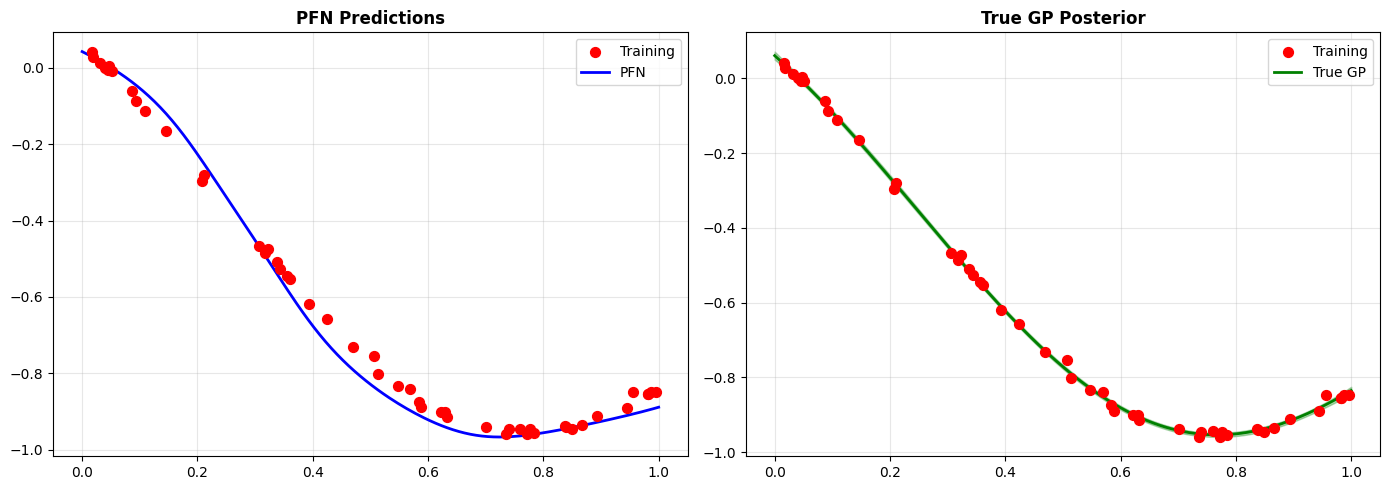

In [ ]:
# =============================================
# VIZUALIZACE - S JEJICH get_batch
# =============================================
import matplotlib.pyplot as plt

model.eval()

# Jejich get_batch
split = 50
x, y, target_y = priors.fast_gp.get_batch(
    batch_size=1,
    seq_len=split + 1,
    num_features=num_features,
    hyperparameters=hps,
    device=device
)

# X grid pro predikce
X_grid = torch.linspace(0, 1, 200).reshape(-1, 1, 1).to(device)

pfn_means = []
with torch.no_grad():
    x_train = x[:split]
    y_train = y[:split]

    for x_test in X_grid:

        x_full = torch.cat([x_train, x_test.unsqueeze(0)], dim=0)
        y_full = torch.cat([y_train, torch.zeros(1, 1).to(device)], dim=0)

        output = model((x_full, y_full), single_eval_pos=split)
        logits = output[0, 0]  # (n_out,)
        mean = criterion.mean(logits.unsqueeze(0)).cpu().item()
        pfn_means.append(mean)

pfn_means = np.array(pfn_means)

# True GP posterior (pomocí sklearn pro porovnání)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X_train_np = x[:split, 0, 0].cpu().numpy().reshape(-1, 1)
y_train_np = y[:split, 0].cpu().numpy()
X_grid_np = X_grid[:, 0, 0].cpu().numpy().reshape(-1, 1)

kernel = 1.0 * RBF(length_scale=0.6)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-4)
gp.fit(X_train_np, y_train_np)
gp_means, gp_stds = gp.predict(X_grid_np, return_std=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_train_np, y_train_np, c='red', s=50, zorder=10, label='Training')
axes[0].plot(X_grid_np, pfn_means, 'b-', lw=2, label='PFN')
axes[0].set_title('PFN Predictions', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_train_np, y_train_np, c='red', s=50, zorder=10, label='Training')
axes[1].plot(X_grid_np, gp_means, 'g-', lw=2, label='True GP')
axes[1].fill_between(X_grid_np.ravel(), gp_means - 2*gp_stds, gp_means + 2*gp_stds, alpha=0.3, color='green')
axes[1].set_title('True GP Posterior', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# =============================================
# SAVE MODEL
# =============================================
import os

save_dir = '/content/PFN_trans'
os.makedirs(save_dir, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'criterion_borders': criterion.borders,
    'config': {
        'lengthscale': hps['lengthscale'],  # OPRAVA: lengthscale, ne length_scale
        'outputscale': hps['outputscale'],
        'noise': hps['noise'],
        'epochs': epochs,
        'emsize': emsize,
        'nhead': nhead,
        'nlayers': nlayers,
        'nhid': nhid,
        'bptt': bptt,
        'num_borders': num_borders,
    },
    'history': history,
}, f'{save_dir}/pfn_gp_model.pth')

print(f"✓ Model uložen do {save_dir}/pfn_gp_model.pth")

✓ Model uložen do /content/PFN_trans/pfn_gp_model.pth
